#Glaucoma Detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
%cd /content/
!mkdir dataset
!cp '/content/drive/MyDrive/DatasetCollection/Glaucoma-DR/Glaucoma/eurecom-aml-2021-challenge-2.zip' dataset
%cd /content/dataset/
!unzip -q eurecom-aml-2021-challenge-2.zip

/content
mkdir: cannot create directory ‘dataset’: File exists
^C
/content/dataset
[eurecom-aml-2021-challenge-2.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of eurecom-aml-2021-challenge-2.zip or
        eurecom-aml-2021-challenge-2.zip.zip, and cannot find eurecom-aml-2021-challenge-2.zip.ZIP, period.


In [ ]:
!ls -lrth 

total 1.7G
-rw-r--r-- 1 root root 5.5K Apr 22  2021 sample_submission.csv
-rw------- 1 root root 1.7G May  1 06:36 eurecom-aml-2021-challenge-2.zip
drwxr-xr-x 3 root root 4.0K May  1 06:36 refuge_data


In [ ]:
%cd '/content/drive/Othercomputers/My Laptop/MTECH_IIT/classes/5th semester/DLOps/project/'

/content/drive/Othercomputers/My Laptop/MTECH_IIT/classes/5th semester/DLOps/project


In [ ]:
!ls -lrth '/content/drive/Othercomputers/My Laptop/MTECH_IIT/classes/5th semester/DLOps/project/glucoma_unet_model1'
project_home_dir='/content/drive/Othercomputers/My Laptop/MTECH_IIT/classes/5th semester/DLOps/project/glucoma_unet_model1'

total 132M
-rw------- 1 root root 813 Dec 21 09:42 best_AUC_classifier.pkl
-rw------- 1 root root 66M Dec 21 09:43 best_AUC_weights.pth
-rw------- 1 root root 813 May  1 08:41 best_AUC_classifier1.pkl
-rw------- 1 root root 66M May  1 08:41 best_AUC_weights1.pth


# Imports

In [ ]:
_=!pip install wandb

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 144 kB 38.7 MB/s 
     |████████████████████████████████| 181 kB 55.1 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=aacdc201c5f14c6f8abf727a8d1475719dd6418c4c341ef227a0d2999bc4838c
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import wandb
##################
wandb.login()
#####################

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
_=!pip install onnx
_=!pip install onnxruntime

In [ ]:
import os
import json
import csv
import random
import seaborn as sns
import pickle
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage.measurements import label
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow as tf
import matplotlib.pyplot as plt
import random

import torchvision.models as models
import os

In [ ]:
##############################################################
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"
##############################################################

In [ ]:
####################################################################
#GPU using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
####################################################################

device(type='cpu')

In [ ]:
_=!pip install showit
from showit import image as draw_image
from showit import tile as draw_tile

# Dataset class

In [ ]:
class RefugeDataset(Dataset):

    def __init__(self, root_dir, split='train', output_size=(256,256)):
        # Define attributes
        self.output_size = output_size
        self.root_dir = root_dir
        self.split = split
        
        # Load data index
        with open(os.path.join(self.root_dir, self.split, 'index.json')) as f:
            self.index = json.load(f)
            
        self.images = []
        for k in range(len(self.index)):
            print('Loading {} image {}/{}...'.format(split, k, len(self.index)), end='\r')
            img_name = os.path.join(self.root_dir, self.split, 'images', self.index[str(k)]['ImgName'])
            img = np.array(Image.open(img_name).convert('RGB'))
            img = transforms.functional.to_tensor(img)
            img = transforms.functional.resize(img, self.output_size, interpolation=Image.BILINEAR)
            self.images.append(img)
            
        # Load ground truth for 'train' and 'val' sets
        if split != 'test':
            self.segs = []
            for k in range(len(self.index)):
                print('Loading {} segmentation {}/{}...'.format(split, k, len(self.index)), end='\r')
                seg_name = os.path.join(self.root_dir, self.split, 'gts', self.index[str(k)]['ImgName'].split('.')[0]+'.bmp')
                seg = np.array(Image.open(seg_name)).copy()
                seg = 255. - seg
                od = (seg>=127.).astype(np.float32)
                oc = (seg>=250.).astype(np.float32)
                od = torch.from_numpy(od[None,:,:])
                oc = torch.from_numpy(oc[None,:,:])
                od = transforms.functional.resize(od, self.output_size, interpolation=Image.NEAREST)
                oc = transforms.functional.resize(oc, self.output_size, interpolation=Image.NEAREST)
                seg = torch.cat([od, oc], dim=0)
                self.segs.append(seg)
                
        print('Succesfully loaded {} dataset.'.format(split) + ' '*50)
            
            
    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        # Image
        img = self.images[idx]
    
        # Return only images for 'test' set
        if self.split == 'test':
            return img
        
        # Else, images and ground truth
        else:
            # Label
            lab = torch.tensor(self.index[str(idx)]['Label'], dtype=torch.float32)

            # Segmentation masks
            seg = self.segs[idx]

            # Fovea localization
            f_x = self.index[str(idx)]['Fovea_X']
            f_y = self.index[str(idx)]['Fovea_Y']
            fov = torch.FloatTensor([f_x, f_y])
        
            return img, lab, seg, fov, self.index[str(idx)]['ImgName']

# Metrics

In [ ]:
EPS = 1e-7

# Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images.

def compute_dice_coef(input, target):
    batch_size = input.shape[0]
    return sum([dice_coef_sample(input[k,:,:], target[k,:,:]) for k in range(batch_size)])/batch_size

def dice_coef_sample(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection) / (iflat.sum() + tflat.sum())


def vertical_diameter(binary_segmentation):
    '''
    Get the vertical diameter from a binary segmentation.
    The vertical diameter is defined as the "fattest" area of the binary_segmentation parameter.
    '''

    # get the sum of the pixels in the vertical axis
    vertical_axis_diameter = np.sum(binary_segmentation, axis=1)

    # pick the maximum value
    diameter = np.max(vertical_axis_diameter, axis=1)

    # return it
    return diameter

def vertical_cup_to_disc_ratio(od, oc):
    '''
    Compute the vertical cup-to-disc ratio from a given labelling map.
    '''
    # compute the cup diameter
    cup_diameter = vertical_diameter(oc)
    # compute the disc diameter
    disc_diameter = vertical_diameter(od)

    return cup_diameter / (disc_diameter + EPS)

def compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc):
    '''
    Compute vCDR prediction error, along with predicted vCDR and ground truth vCDR.
    '''
    pred_vCDR = vertical_cup_to_disc_ratio(pred_od, pred_oc)
    gt_vCDR = vertical_cup_to_disc_ratio(gt_od, gt_oc)
    vCDR_err = np.mean(np.abs(gt_vCDR - pred_vCDR))
    return vCDR_err, pred_vCDR, gt_vCDR


def classif_eval(classif_preds, classif_gts):
    '''
    Compute AUC classification score.
    '''
    auc = roc_auc_score(classif_gts, classif_preds)
    return auc


def fov_error(pred_fov, gt_fov):
    '''
    Fovea localization error metric (mean root squared error).
    '''
    err = np.sqrt(np.sum((gt_fov-pred_fov)**2, axis=1)).mean()
    return err

# Post processing functions

In [ ]:
def refine_seg(pred):
    '''
    Only retain the biggest connected component of a segmentation map.
    '''
    np_pred = pred.numpy()
        
    largest_ccs = []
    for i in range(np_pred.shape[0]):
        #print(label(np_pred[i,:,:]))
        #labeled, ncomponents = label(np_pred[i,:,:])
        labeled = np_pred[i,:,:]
        bincounts = np.bincount(labeled.flat)[1:]
        if len(bincounts) == 0:
            largest_cc = labeled == 0
        else:
            largest_cc = labeled == np.argmax(bincounts)+1
        largest_cc = torch.tensor(largest_cc, dtype=torch.float32)
        largest_ccs.append(largest_cc)
    largest_ccs = torch.stack(largest_ccs)
    
    return largest_ccs

# Network

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.epoch = 0

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.output_layer = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        out = self.up1(x5, x4)
        out = self.up2(out, x3)
        out = self.up3(out, x2)
        out = self.up4(out, x1)
        out = self.output_layer(out)
        out = torch.sigmoid(out)
        return out

    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Use the normal convolutions to reduce the number of channels
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    '''
    Simple convolution.
    '''
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Settings

In [ ]:
config = dict(
    saved_path_class="./glucoma_unet_model1/best_AUC_classifier1.pkl",
    saved_path_weight="./glucoma_unet_model1/best_AUC_weights1.pth",
    ROOT_DIR='/content/dataset/refuge_data/refuge_data',
    lr = 1e-4, 
    EPOCHS = 100,
    BATCH_SIZE = 8,
    IMAGE_SIZE = 224,
    TRAIN_VALID_SPLIT = 0.2,
    NUM_WORKERS = 8,
    device=device,)

In [ ]:
#Initiate the Project and Entity
wandb.init(project="dlops-project", config=config)
# access all HPs through wandb.config, so logging matches execution!
config = wandb.config

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
test_accuracy,▃▁▁▂▅▄▅▃▆▇█▇▇▆█▇▇█▇█▇█
epoch,23
loss,0.05715
test_accuracy,0.89771


In [ ]:
# root_dir = '/content/dataset/refuge_data/refuge_data'
# lr = 1e-4
# batch_size = 8
# num_workers = 8
# total_epoch = 100

# Create datasets and data loaders
All image files are loaded in RAM in order to speed up the pipeline. Therefore, each dataset creation should take a few minutes.

In [ ]:
# Datasets
train_set = RefugeDataset(config.ROOT_DIR, split='train')
val_set = RefugeDataset(config.ROOT_DIR, split='val')
test_set = RefugeDataset(config.ROOT_DIR, split='test')


# Dataloaders
train_loader = DataLoader(train_set, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:424: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Succesfully loaded train dataset.                                                  
Succesfully loaded val dataset.                                                  
Succesfully loaded test dataset.                                                  


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Let's see the data

In [ ]:
def ratio_gl(list):
    n=0
    for i in range(len(list)):
        if list[i][1] == 1 : 
            n+=1
    return n / len(list)

print('Ratio of glaucaumous images :',  ratio_gl(train_set))

Ratio of glaucaumous images : 0.1


It is an imbalancer data set. Working with such a distribution will have a negative impact classifying images from under represented classes. We will use data augmentation.

#Some useful functions

In [ ]:
def show_image(image):
    plt.figure(figsize=(10,10))
    #Before showing image, bgr color order transformed to rgb order
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def rotate(sample,degrees):
    res=[]
    for i in range(4):
        res.append(torch.clone(sample[i]))
    res.append(sample[4])
    
    for i in range(3):
        
        image= Image.fromarray(sample[0][i].cpu().detach().numpy())
        rotated = Image.Image.rotate(image, degrees)
        res[0][i]=torch.from_numpy(np.array(rotated))
        
    for i in range(2):
        image= Image.fromarray(sample[2][i].cpu().detach().numpy())
        rotated = Image.Image.rotate(image, degrees)
        res[2][i]=torch.from_numpy(np.array(rotated))
    return res

#Data augmentation
## Data balance

In [ ]:
#import tensorflow as tf
l = len(train_set)


while ratio_gl(train_set) < 0.5:
    for i in range(l):
        if train_set[i][1] == 1:
            train_set = (*train_set, train_set[i])
    print('New ratio', ratio_gl(train_set))

New ratio 0.18181818181818182
New ratio 0.25
New ratio 0.3076923076923077
New ratio 0.35714285714285715
New ratio 0.4
New ratio 0.4375
New ratio 0.47058823529411764
New ratio 0.5


In [ ]:
def change_color_toHSV(data, nb_change):
    n = len(data)
    i  = 0
    while i <= nb_change & i < n:
        j = random.uniform(0,n)
        tmp = rotate(data[j],random.uniform(-30,30))
        data = (*data, tmp)

#Device, model, loss and optimizer

In [ ]:
# https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_deep-learning-computation/use-gpu.ipynb#scrollTo=M0QpWR4wSzUS
def try_gpu(i=0):  
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
# Device
#device = torch.device("cuda:0")
device = try_gpu()

# Network
model = UNet(n_channels=3, n_classes=2).to(device)

# Loss
seg_loss = torch.nn.BCELoss(reduction='mean')

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=config.get('lr'))

# Train for OC/OD segmentation

In [ ]:
epoch = []
train_loss_l = []
val_loss_l= []
train_dsc_od_l= []
val_dsc_od_l= []
train_dsc_oc_l= []
val_dsc_oc_l= []
train_vCDR_error_l= []
val_vCDR_error_l= []
train_auc_l= []
val_auc_l= []

In [ ]:
# Define parameters
nb_train_batches = len(train_loader)
nb_val_batches = len(val_loader)
nb_iter = 0
best_val_auc = 0.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 1                                                  
LOSSES: 0.4218 (train), 0.3935 (val)
OD segmentation (Dice Score): 0.8468 (train), 0.5333 (val)
OC segmentation (Dice Score): 0.5793 (train), 0.3747 (val)
vCDR error: 0.7671 (train), 10.2795 (val)
Classification (AUC): 0.6799 (train), 0.5628 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


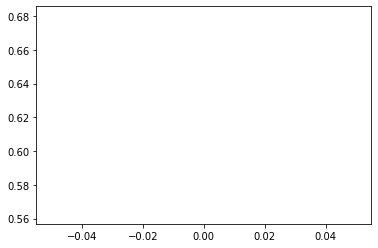

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 2                                                  
LOSSES: 0.3374 (train), 0.3424 (val)
OD segmentation (Dice Score): 0.9119 (train), 0.3267 (val)
OC segmentation (Dice Score): 0.7369 (train), 0.0077 (val)
vCDR error: 0.3586 (train), 20.8197 (val)
Classification (AUC): 0.8302 (train), 0.3972 (val)
__________________________________________________


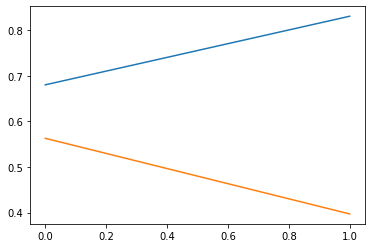

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 3                                                  
LOSSES: 0.3045 (train), 0.3025 (val)
OD segmentation (Dice Score): 0.9116 (train), 0.3903 (val)
OC segmentation (Dice Score): 0.7187 (train), 0.4931 (val)
vCDR error: 0.4465 (train), 7.0443 (val)
Classification (AUC): 0.1819 (train), 0.4163 (val)
__________________________________________________


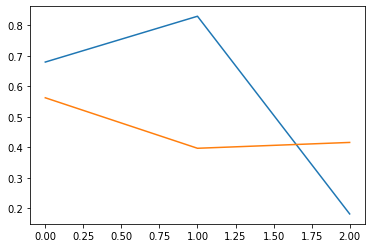

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 4                                                  
LOSSES: 0.2750 (train), 0.2795 (val)
OD segmentation (Dice Score): 0.9281 (train), 0.3360 (val)
OC segmentation (Dice Score): 0.7918 (train), 0.4727 (val)
vCDR error: 0.2041 (train), 5.1666 (val)
Classification (AUC): 0.8765 (train), 0.5047 (val)
__________________________________________________


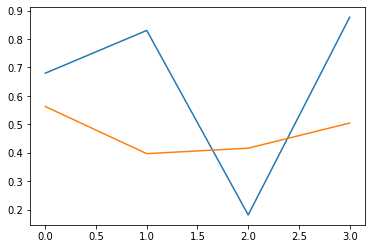

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 5                                                  
LOSSES: 0.2502 (train), 0.2498 (val)
OD segmentation (Dice Score): 0.9349 (train), 0.6664 (val)
OC segmentation (Dice Score): 0.8235 (train), 0.5729 (val)
vCDR error: 0.1179 (train), 4.6288 (val)
Classification (AUC): 0.8832 (train), 0.7255 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


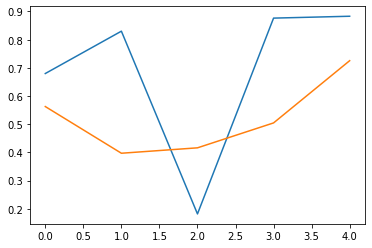

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 6                                                  
LOSSES: 0.2285 (train), 0.2329 (val)
OD segmentation (Dice Score): 0.9399 (train), 0.8297 (val)
OC segmentation (Dice Score): 0.8346 (train), 0.4929 (val)
vCDR error: 0.0865 (train), 1.7772 (val)
Classification (AUC): 0.9014 (train), 0.5996 (val)
__________________________________________________


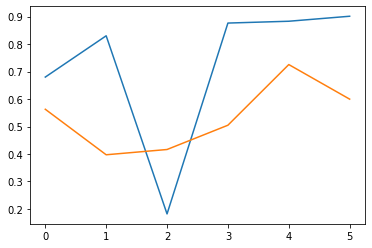

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 7                                                  
LOSSES: 0.2080 (train), 0.2216 (val)
OD segmentation (Dice Score): 0.9460 (train), 0.7838 (val)
OC segmentation (Dice Score): 0.8490 (train), 0.7201 (val)
vCDR error: 0.0628 (train), 0.2493 (val)
Classification (AUC): 0.8785 (train), 0.7062 (val)
__________________________________________________


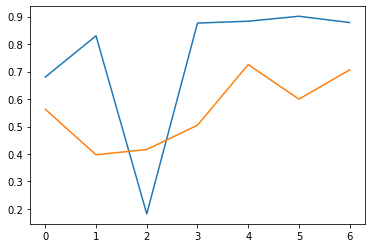

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 8                                                  
LOSSES: 0.1898 (train), 0.1943 (val)
OD segmentation (Dice Score): 0.9492 (train), 0.5679 (val)
OC segmentation (Dice Score): 0.8552 (train), 0.3757 (val)
vCDR error: 0.0918 (train), 6.1815 (val)
Classification (AUC): 0.8731 (train), 0.5430 (val)
__________________________________________________


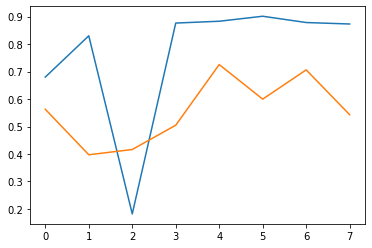

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 9                                                  
LOSSES: 0.1740 (train), 0.1784 (val)
OD segmentation (Dice Score): 0.9420 (train), 0.8231 (val)
OC segmentation (Dice Score): 0.8465 (train), 0.7327 (val)
vCDR error: 0.0599 (train), 0.8966 (val)
Classification (AUC): 0.9236 (train), 0.7971 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


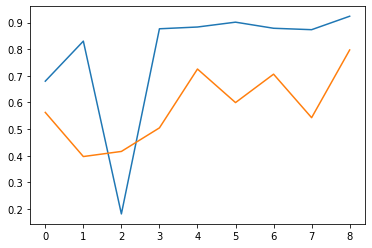

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 10                                                  
LOSSES: 0.1593 (train), 0.1605 (val)
OD segmentation (Dice Score): 0.9492 (train), 0.8695 (val)
OC segmentation (Dice Score): 0.8512 (train), 0.7592 (val)
vCDR error: 0.0615 (train), 0.7195 (val)
Classification (AUC): 0.9100 (train), 0.8208 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


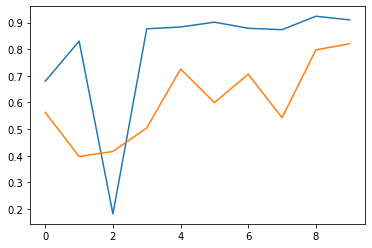

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 11                                                  
LOSSES: 0.1462 (train), 0.1495 (val)
OD segmentation (Dice Score): 0.9515 (train), 0.8211 (val)
OC segmentation (Dice Score): 0.8628 (train), 0.7752 (val)
vCDR error: 0.0566 (train), 1.4380 (val)
Classification (AUC): 0.9066 (train), 0.9026 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


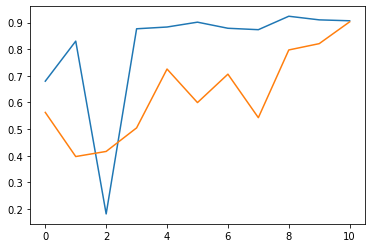

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 12                                                  
LOSSES: 0.1343 (train), 0.1393 (val)
OD segmentation (Dice Score): 0.9561 (train), 0.6937 (val)
OC segmentation (Dice Score): 0.8598 (train), 0.7004 (val)
vCDR error: 0.0582 (train), 1.6862 (val)
Classification (AUC): 0.9331 (train), 0.8305 (val)
__________________________________________________


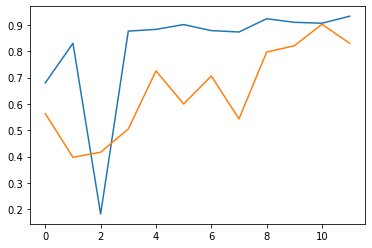

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 13                                                  
LOSSES: 0.1238 (train), 0.1286 (val)
OD segmentation (Dice Score): 0.9548 (train), 0.8572 (val)
OC segmentation (Dice Score): 0.8606 (train), 0.7723 (val)
vCDR error: 0.0578 (train), 0.6480 (val)
Classification (AUC): 0.9282 (train), 0.8587 (val)
__________________________________________________


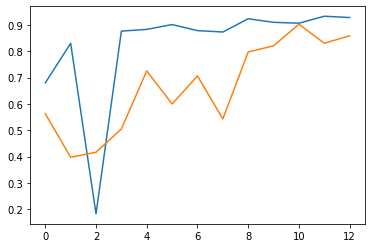

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 14                                                  
LOSSES: 0.1142 (train), 0.1212 (val)
OD segmentation (Dice Score): 0.9573 (train), 0.6879 (val)
OC segmentation (Dice Score): 0.8664 (train), 0.5878 (val)
vCDR error: 0.0541 (train), 3.0620 (val)
Classification (AUC): 0.9553 (train), 0.8070 (val)
__________________________________________________


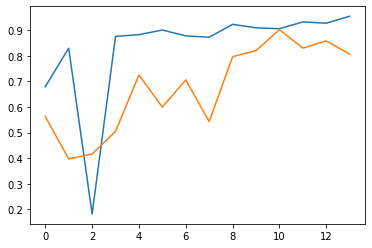

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 15                                                  
LOSSES: 0.1057 (train), 0.1100 (val)
OD segmentation (Dice Score): 0.9568 (train), 0.8624 (val)
OC segmentation (Dice Score): 0.8679 (train), 0.7657 (val)
vCDR error: 0.0548 (train), 0.5222 (val)
Classification (AUC): 0.9339 (train), 0.8952 (val)
__________________________________________________


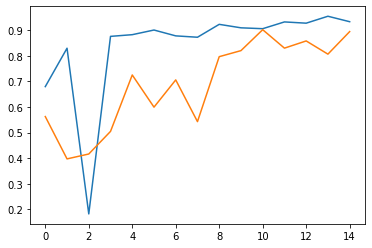

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 16                                                  
LOSSES: 0.0978 (train), 0.1102 (val)
OD segmentation (Dice Score): 0.9576 (train), 0.8448 (val)
OC segmentation (Dice Score): 0.8679 (train), 0.7318 (val)
vCDR error: 0.0546 (train), 0.1253 (val)
Classification (AUC): 0.9547 (train), 0.8742 (val)
__________________________________________________


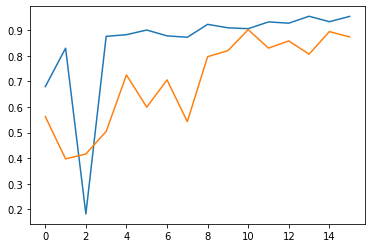

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 17                                                  
LOSSES: 0.0907 (train), 0.0988 (val)
OD segmentation (Dice Score): 0.9599 (train), 0.6380 (val)
OC segmentation (Dice Score): 0.8696 (train), 0.6675 (val)
vCDR error: 0.0560 (train), 1.8082 (val)
Classification (AUC): 0.9002 (train), 0.8228 (val)
__________________________________________________


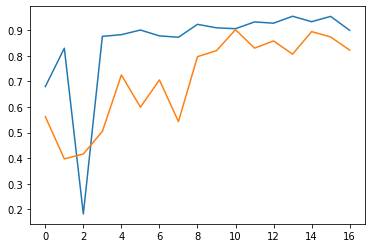

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 18                                                  
LOSSES: 0.0844 (train), 0.0894 (val)
OD segmentation (Dice Score): 0.9557 (train), 0.8999 (val)
OC segmentation (Dice Score): 0.8678 (train), 0.7390 (val)
vCDR error: 0.0526 (train), 0.2003 (val)
Classification (AUC): 0.9484 (train), 0.8944 (val)
__________________________________________________


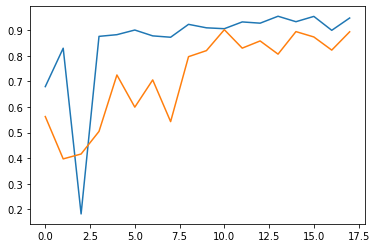

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 19                                                  
LOSSES: 0.0783 (train), 0.0867 (val)
OD segmentation (Dice Score): 0.9604 (train), 0.7529 (val)
OC segmentation (Dice Score): 0.8720 (train), 0.6734 (val)
vCDR error: 0.0514 (train), 1.7421 (val)
Classification (AUC): 0.9666 (train), 0.8165 (val)
__________________________________________________


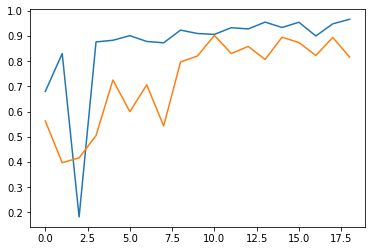

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 20                                                  
LOSSES: 0.0730 (train), 0.0753 (val)
OD segmentation (Dice Score): 0.9616 (train), 0.8921 (val)
OC segmentation (Dice Score): 0.8771 (train), 0.7686 (val)
vCDR error: 0.0498 (train), 0.1530 (val)
Classification (AUC): 0.9497 (train), 0.9297 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


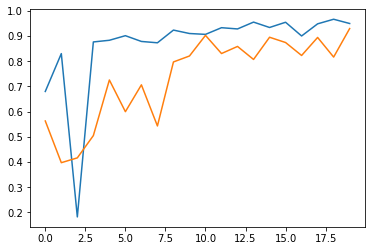

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 21                                                  
LOSSES: 0.0681 (train), 0.0713 (val)
OD segmentation (Dice Score): 0.9623 (train), 0.8278 (val)
OC segmentation (Dice Score): 0.8775 (train), 0.8039 (val)
vCDR error: 0.0485 (train), 0.1975 (val)
Classification (AUC): 0.9698 (train), 0.8881 (val)
__________________________________________________


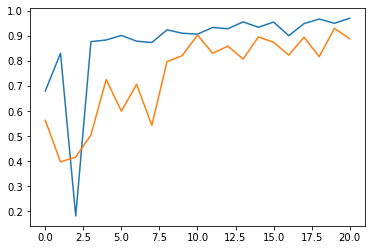

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION epoch 22                                                  
LOSSES: 0.0636 (train), 0.0678 (val)
OD segmentation (Dice Score): 0.9639 (train), 0.8966 (val)
OC segmentation (Dice Score): 0.8823 (train), 0.7954 (val)
vCDR error: 0.0482 (train), 0.1682 (val)
Classification (AUC): 0.9414 (train), 0.8977 (val)
__________________________________________________


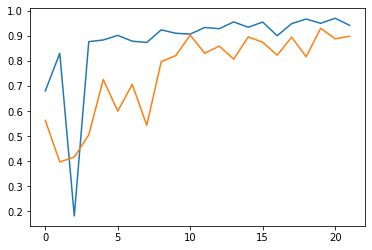

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

In [ ]:
while model.epoch < 50:
    # Accumulators
    train_vCDRs, val_vCDRs = [], []
    train_classif_gts, val_classif_gts = [], []
    train_loss, val_loss = 0., 0.
    train_dsc_od, val_dsc_od = 0., 0.
    train_dsc_oc, val_dsc_oc = 0., 0.
    train_vCDR_error, val_vCDR_error = 0., 0.
    
    ############
    # TRAINING #
    ############
    model.train()
    train_data = iter(train_loader)

    ############################################################
    # tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, seg_loss, log="all", log_freq=10)
    ############################################################
    

    for k in range(nb_train_batches):
        # Loads data
        imgs, classif_gts, seg_gts, fov_coords, names = train_data.next()
        imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

        # Forward pass
        logits = model(imgs)
        loss = seg_loss(logits, seg_gts)
 
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / nb_train_batches
        
        with torch.no_grad():
            # Compute segmentation metric
            pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            gt_od = seg_gts[:,0,:,:].type(torch.int8)
            gt_oc = seg_gts[:,1,:,:].type(torch.int8)
            dsc_od = compute_dice_coef(pred_od, gt_od)
            dsc_oc = compute_dice_coef(pred_oc, gt_oc)
            train_dsc_od += dsc_od.item()/nb_train_batches
            train_dsc_oc += dsc_oc.item()/nb_train_batches


            # Compute and store vCDRs
            vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
            train_vCDRs += pred_vCDR.tolist()
            train_vCDR_error += vCDR_error / nb_train_batches
            train_classif_gts += classif_gts.cpu().numpy().tolist()
            
        # Increase iterations
        nb_iter += 1
        
        # Std out
        print('Epoch {}, iter {}/{}, loss {:.6f}'.format(model.epoch+1, k+1, nb_train_batches, loss.item()) + ' '*20, 
              end='\r')
        wandb.log({"epoch": model.epoch+1, "loss": loss.item()}, step=nb_iter)
    
    
    # Train a logistic regression on vCDRs
    train_vCDRs = np.array(train_vCDRs).reshape(-1,1)
    train_classif_gts = np.array(train_classif_gts)
    clf = LogisticRegression(random_state=0, solver='lbfgs').fit(train_vCDRs, train_classif_gts)
    train_classif_preds = clf.predict_proba(train_vCDRs)[:,1]
    train_auc = classif_eval(train_classif_preds, train_classif_gts)
    
    ##############
    # VALIDATION #
    ##############
    model.eval()
    with torch.no_grad():
        val_data = iter(val_loader)
        for k in range(nb_val_batches):
            # Loads data
            imgs, classif_gts, seg_gts, fov_coords, names = val_data.next()
            imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

            # Forward pass
            logits = model(imgs)
            val_loss += seg_loss(logits, seg_gts).item() / nb_val_batches

            # Std out
            print('Validation iter {}/{}'.format(k+1, nb_val_batches) + ' '*50, 
                  end='\r')
            
            # Compute segmentation metric
            pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            gt_od = seg_gts[:,0,:,:].type(torch.int8)
            gt_oc = seg_gts[:,1,:,:].type(torch.int8)
            dsc_od = compute_dice_coef(pred_od, gt_od)
            dsc_oc = compute_dice_coef(pred_oc, gt_oc)
            val_dsc_od += dsc_od.item()/nb_val_batches
            val_dsc_oc += dsc_oc.item()/nb_val_batches
            
            # Compute and store vCDRs
            vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
            val_vCDRs += pred_vCDR.tolist()
            val_vCDR_error += vCDR_error / nb_val_batches
            val_classif_gts += classif_gts.cpu().numpy().tolist()
            

    # Glaucoma predictions from vCDRs
    val_vCDRs = np.array(val_vCDRs).reshape(-1,1)
    val_classif_gts = np.array(val_classif_gts)
    val_classif_preds = clf.predict_proba(val_vCDRs)[:,1]
    val_auc = classif_eval(val_classif_preds, val_classif_gts)
        
    # Validation results
    print('VALIDATION epoch {}'.format(model.epoch+1)+' '*50)
    print('LOSSES: {:.4f} (train), {:.4f} (val)'.format(train_loss, val_loss))
    print('OD segmentation (Dice Score): {:.4f} (train), {:.4f} (val)'.format(train_dsc_od, val_dsc_od))
    print('OC segmentation (Dice Score): {:.4f} (train), {:.4f} (val)'.format(train_dsc_oc, val_dsc_oc))
    print('vCDR error: {:.4f} (train), {:.4f} (val)'.format(train_vCDR_error, val_vCDR_error))
    print('Classification (AUC): {:.4f} (train), {:.4f} (val)'.format(train_auc, val_auc))
    
    wandb.log({"test_accuracy": val_auc})

    # Save model if best validation AUC is reached
    if val_auc > best_val_auc:
        torch.save(model.state_dict(), './glucoma_unet_model1/best_AUC_weights1.pth')
        with open('./glucoma_unet_model1/best_AUC_classifier1.pkl', 'wb') as clf_file:
            pickle.dump(clf, clf_file)
        best_val_auc = val_auc
        print('Best validation AUC reached. Saved model weights and classifier.')
    print('_'*50)
        
    # End of epoch
    epoch.append(model.epoch)
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_dsc_od_l.append(train_dsc_od)
    val_dsc_od_l.append(val_dsc_od)
    train_dsc_oc_l.append(train_dsc_oc)
    val_dsc_oc_l.append(val_dsc_oc)
    train_vCDR_error_l.append(train_vCDR_error)
    val_vCDR_error_l.append(val_vCDR_error)
    train_auc_l.append(train_auc)
    val_auc_l.append(val_auc)
    model.epoch += 1
    
    plt.plot(epoch,train_auc_l)
    plt.plot(epoch,val_auc_l)
    plt.show()

## Load best model + classifier

In [ ]:
# Load model and classifier
model = UNet(n_channels=3, n_classes=2).to(device)
model.load_state_dict(torch.load('./glucoma_unet_model1/best_AUC_weights.pth',map_location=device))
with open('./glucoma_unet_model1/best_AUC_classifier.pkl', 'rb') as clf_file:
    clf = pickle.load(clf_file)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


## Model Conversion to ONXX

In [ ]:
!rm -rf "./triton_model_repository"
os.makedirs("./triton_model_repository/unet_torch/1")
os.makedirs("./triton_model_repository/unet_onnx/1")
os.makedirs("./triton_model_repository/unet_trt_fp32/1")
os.makedirs("./triton_model_repository/unet_trt_fp16/1")

In [ ]:
PY_MODEL_PATH_WEIGHT = './glucoma_unet_model1/best_AUC_weights.pth'
JIT_MODEL_PATH_WEIGHT = './triton_model_repository/unet_torch/1/model_weight.pt'
ONNX_MODEL_PATH_WEIGHT = './triton_model_repository/unet_onnx/1/model_weight.onnx'

TRT_MODEL_PATH = './triton_model_repository/unet_trt_fp32/1/model.plan'
TRT_MODEL_PATH_FP16 = './triton_model_repository/unet_trt_fp16/1/model.plan'

In [ ]:
model.eval()

CHANNEL_LAST = False
BATCH_SIZE = config.BATCH_SIZE
INPUT_SHAPE = (3, 224, 224)

if CHANNEL_LAST:
    example = torch.randn((BATCH_SIZE, *INPUT_SHAPE), dtype=torch.float32, device=device).to(memory_format=torch.channels_last)
else:
    example = torch.randn((BATCH_SIZE, *INPUT_SHAPE), dtype=torch.float32, device=device)

script = torch.jit.trace(model, example)
script.save(JIT_MODEL_PATH_WEIGHT)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


## Export to ONNX

In [ ]:
if CHANNEL_LAST:
    x = torch.randn((1, *INPUT_SHAPE), dtype=torch.float32, device=device).to(memory_format=torch.channels_last)
else:
    x = torch.randn((1, *INPUT_SHAPE), dtype=torch.float32, device=device)

torch.onnx.export(model,                       # model being run
                  x,                           # model input (or a tuple for multiple inputs)
                  ONNX_MODEL_PATH_WEIGHT,             # Path to saved onnx model
                  export_params=True,          # store the trained parameter weights inside the model file
                  opset_version=13,            # the ONNX version to export the model to
                  input_names = ['input'],     # the model's input names
                  output_names = ['output'],   # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [ ]:
# !ls -LR triton_model_repository
_=!pip install seedir
import seedir as sd
sd.seedir('triton_model_repository', style='emoji')

📁 triton_model_repository/
├─📁 unet_torch/
│ └─📁 1/
│   └─📄 model_weight.pt
├─📁 unet_onnx/
│ └─📁 1/
│   └─📄 model_weight.onnx
├─📁 unet_trt_fp32/
│ └─📁 1/
└─📁 unet_trt_fp16/
  └─📁 1/


## Check performance is maintained on validation

In [ ]:
model.eval()
val_vCDRs = []
val_classif_gts = []
val_loss = 0.
val_dsc_od = 0.
val_dsc_oc = 0.
val_vCDR_error = 0.
with torch.no_grad():
    val_data = iter(val_loader)
    for k in range(nb_val_batches):
        # Loads data
        imgs, classif_gts, seg_gts, fov_coords, names = val_data.next()
        imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

        # Forward pass
        logits = model(imgs)
        val_loss += seg_loss(logits, seg_gts).item() / nb_val_batches

        # Std out
        print('Validation iter {}/{}'.format(k+1, nb_val_batches) + ' '*50, 
              end='\r')

        # Compute segmentation metric
        pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
        pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
        gt_od = seg_gts[:,0,:,:].type(torch.int8)
        gt_oc = seg_gts[:,1,:,:].type(torch.int8)
        dsc_od = compute_dice_coef(pred_od, gt_od)
        dsc_oc = compute_dice_coef(pred_oc, gt_oc)
        val_dsc_od += dsc_od.item()/nb_val_batches
        val_dsc_oc += dsc_oc.item()/nb_val_batches

        # Compute and store vCDRs
        vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
        val_vCDRs += pred_vCDR.tolist()
        val_vCDR_error += vCDR_error / nb_val_batches
        val_classif_gts += classif_gts.cpu().numpy().tolist()


# Glaucoma predictions from vCDRs
val_vCDRs = np.array(val_vCDRs).reshape(-1,1)
val_classif_gts = np.array(val_classif_gts)
val_classif_preds = clf.predict_proba(val_vCDRs)[:,1]
val_auc = classif_eval(val_classif_preds, val_classif_gts)

# Validation results
print('VALIDATION '+' '*50)
print('LOSSES: {:.4f} (val)'.format(val_loss))
print('OD segmentation (Dice Score): {:.4f} (val)'.format(val_dsc_od))
print('OC segmentation (Dice Score): {:.4f} (val)'.format(val_dsc_oc))
print('vCDR error: {:.4f} (val)'.format(val_vCDR_error))
print('Classification (AUC): {:.4f} (val)'.format(val_auc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


VALIDATION                                                   
LOSSES: 0.0645 (val)
OD segmentation (Dice Score): 0.9167 (val)
OC segmentation (Dice Score): 0.8082 (val)
vCDR error: 0.0965 (val)
Classification (AUC): 0.9189 (val)


### inference for single image

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:424: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


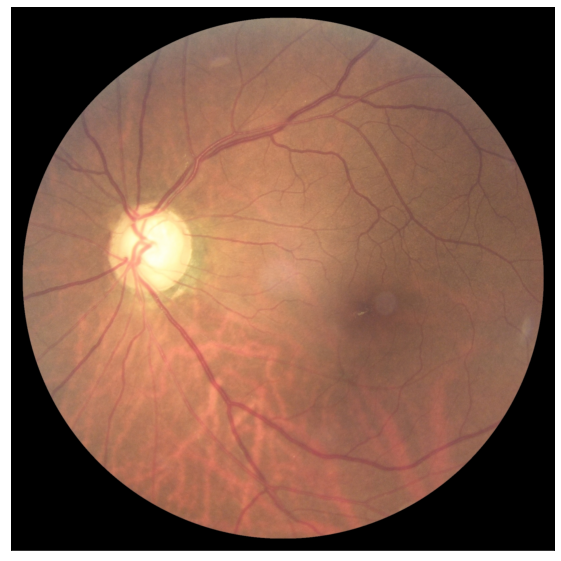

[0.73333335]
[[0.72433507 0.27566493]]


In [ ]:
image_path = "/content/drive/MyDrive/DatasetCollection/Glaucoma-DR/Glaucoma/refuge_data/val/images/V0006.jpg"
output_size=(256,256)
img = np.array(Image.open(image_path).convert('RGB'))
img = transforms.functional.to_tensor(img)
img = transforms.functional.resize(img, output_size, interpolation=Image.BILINEAR)
model.to(device)
show_image(cv2.imread(image_path))
model.eval()
logits = model(img[None,:])

# Compute segmentation metric
pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)

# Compute and store vCDRs
pred_vCDR = vertical_cup_to_disc_ratio(pred_od.cpu().numpy(), pred_oc.cpu().numpy())
print(pred_vCDR)
test_classif_preds = clf.predict_proba(np.array(pred_vCDR).reshape(-1,1))
print(test_classif_preds)

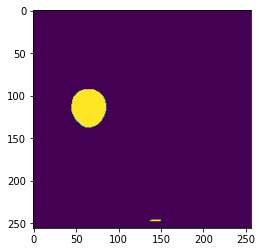

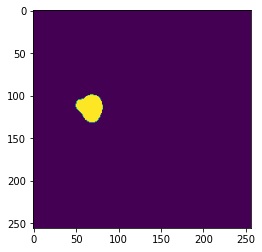

In [ ]:
# pred_od[0].cpu().detach().numpy()
from matplotlib.pyplot import imshow
imshow(pred_od[0].cpu().detach().numpy())
plt.show()
imshow(pred_oc[0].cpu().detach().numpy())

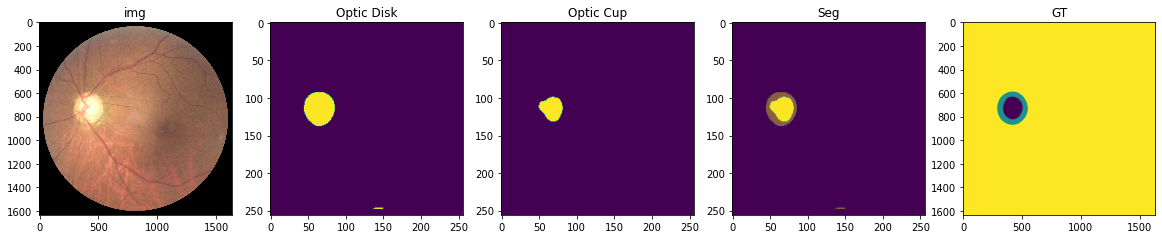

In [ ]:
im2display = Image.open(image_path).convert('RGB')
gt = Image.open(image_path.replace('images','gts').replace('jpg','bmp')) #.convert('RGB')

fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(20,10))
ax1.imshow(im2display, interpolation='nearest')
ax1.title.set_text("img")
ax1.grid(False)
ax2.imshow(pred_od[0])
ax2.title.set_text("Optic Disk")
ax2.grid(False)
ax3.imshow(pred_oc[0])
ax3.title.set_text("Optic Cup")
ax3.grid(False)

ax4.imshow(im2display, interpolation='nearest')
ax4.imshow(pred_od[0].cpu().detach().numpy())
ax4.imshow(pred_oc[0].cpu().detach().numpy(),alpha=0.6)
ax4.title.set_text("Seg")
ax4.grid(False)

# ax5.imshow(im2display, interpolation='nearest')
ax5.imshow(gt)
# ax4.imshow(gt[1], alpha=0.5)
ax5.title.set_text("GT")
ax5.grid(False)

plt.show()

# AWS Deployment

In [ ]:
import torch.nn as nn
import torch
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

In [ ]:
EPS = 1e-7
def try_gpu(i=0):  
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
# Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images.

def compute_dice_coef(input, target):
    batch_size = input.shape[0]
    return sum([dice_coef_sample(input[k,:,:], target[k,:,:]) for k in range(batch_size)])/batch_size

def dice_coef_sample(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection) / (iflat.sum() + tflat.sum())


def vertical_diameter(binary_segmentation):
    '''
    Get the vertical diameter from a binary segmentation.
    The vertical diameter is defined as the "fattest" area of the binary_segmentation parameter.
    '''

    # get the sum of the pixels in the vertical axis
    vertical_axis_diameter = np.sum(binary_segmentation, axis=1)

    # pick the maximum value
    diameter = np.max(vertical_axis_diameter, axis=1)

    # return it
    return diameter

def vertical_cup_to_disc_ratio(od, oc):
    '''
    Compute the vertical cup-to-disc ratio from a given labelling map.
    '''
    # compute the cup diameter
    cup_diameter = vertical_diameter(oc)
    # compute the disc diameter
    disc_diameter = vertical_diameter(od)

    return cup_diameter / (disc_diameter + EPS)

def compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc):
    '''
    Compute vCDR prediction error, along with predicted vCDR and ground truth vCDR.
    '''
    pred_vCDR = vertical_cup_to_disc_ratio(pred_od, pred_oc)
    gt_vCDR = vertical_cup_to_disc_ratio(gt_od, gt_oc)
    vCDR_err = np.mean(np.abs(gt_vCDR - pred_vCDR))
    return vCDR_err, pred_vCDR, gt_vCDR


def classif_eval(classif_preds, classif_gts):
    '''
    Compute AUC classification score.
    '''
    auc = roc_auc_score(classif_gts, classif_preds)
    return auc


def fov_error(pred_fov, gt_fov):
    '''
    Fovea localization error metric (mean root squared error).
    '''
    err = np.sqrt(np.sum((gt_fov-pred_fov)**2, axis=1)).mean()
    return err

def refine_seg(pred):
    '''
    Only retain the biggest connected component of a segmentation map.
    '''
    np_pred = pred.numpy()
        
    largest_ccs = []
    for i in range(np_pred.shape[0]):
        #print(label(np_pred[i,:,:]))
        #labeled, ncomponents = label(np_pred[i,:,:])
        labeled = np_pred[i,:,:]
        bincounts = np.bincount(labeled.flat)[1:]
        if len(bincounts) == 0:
            largest_cc = labeled == 0
        else:
            largest_cc = labeled == np.argmax(bincounts)+1
        largest_cc = torch.tensor(largest_cc, dtype=torch.float32)
        largest_ccs.append(largest_cc)
    largest_ccs = torch.stack(largest_ccs)
    
    return largest_ccs

# Device
device = try_gpu()

In [ ]:
# model/ network
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.epoch = 0

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.output_layer = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        out = self.up1(x5, x4)
        out = self.up2(out, x3)
        out = self.up3(out, x2)
        out = self.up4(out, x1)
        out = self.output_layer(out)
        out = torch.sigmoid(out)
        return out

    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Use the normal convolutions to reduce the number of channels
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    '''
    Simple convolution.
    '''
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
# Load model and classifier
project_home_dir='/content/drive/project glucoma/glucoma_unet_model1'
model = UNet(n_channels=3, n_classes=2).to(device)
model.load_state_dict(torch.load('./glucoma_unet_model1/best_AUC_weights.pth',map_location=device))
with open('./glucoma_unet_model1/best_AUC_classifier.pkl', 'rb') as clf_file:
    clf = pickle.load(clf_file)
_=model.eval()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:424: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


vCDR: 0.73333335
Classification :  0.275664928667643


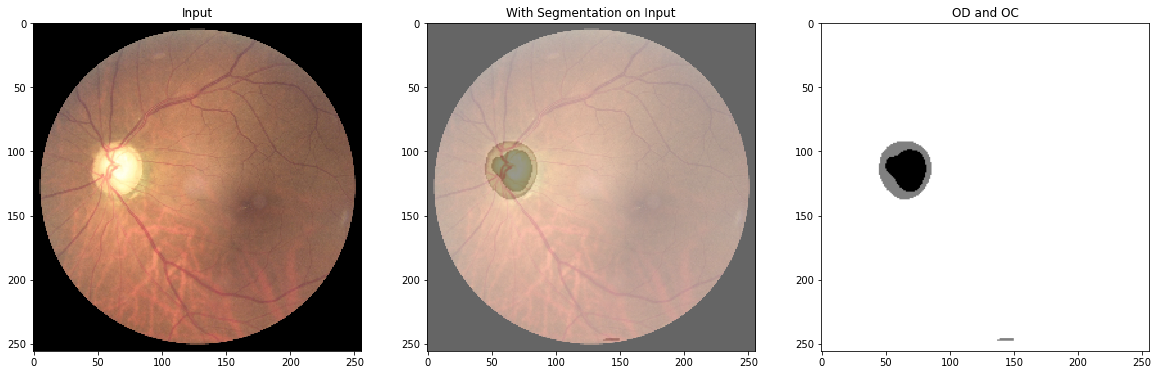

In [ ]:
image_path = '/content/drive/MyDrive/DatasetCollection/Glaucoma-DR/Glaucoma/refuge_data/val/images/V0006.jpg'
output_size=(256,256)
img = np.array(Image.open(image_path).convert('RGB'))
img = transforms.functional.to_tensor(img)
img = transforms.functional.resize(img, output_size, interpolation=Image.BILINEAR)


logits = model(img[None,:])

# Compute segmentation metric
pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)

pred_od = pred_od.cpu().numpy()
pred_oc = pred_oc.cpu().numpy()

# Compute and store vCDRs
pred_vCDR = vertical_cup_to_disc_ratio(pred_od, pred_oc)
print("vCDR:",pred_vCDR[0])
test_classif_preds = clf.predict_proba(np.array(pred_vCDR).reshape(-1,1))[:,1]
print("Classification : ",test_classif_preds[0])

pred_seg = np.zeros((img.shape[1],img.shape[2]), dtype=np.uint8)
pred_seg[:,:]=255
pred_seg[pred_od[0]==1.0]=128
pred_seg[pred_oc[0]==1.0]=0

# ax4.imshow(Image.open(image_path).convert('RGB'), interpolation='nearest')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,10))
ax1.imshow(img.permute(1,2,0), interpolation='nearest')
ax1.title.set_text("Input")
ax1.grid(False)
ax2.imshow(img.permute(1,2,0), interpolation='nearest')
ax2.imshow(cv2.cvtColor(pred_seg, cv2.COLOR_BGR2RGB), alpha=0.4)
ax2.title.set_text("With Segmentation on Input")
ax2.grid(False)
ax3.imshow(cv2.cvtColor(pred_seg, cv2.COLOR_BGR2RGB))
ax3.title.set_text("OD and OC")
ax3.grid(False)
plt.savefig('ouput_result.png')
plt.show()